<a href="https://colab.research.google.com/github/Nacho2904/orga_de_datos/blob/main/tp4_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yu-Gi-Oh Style Transfer

En este notebook implementaremos un algoritmo de **Neural Style Transfer** (NST) basado en [Gatys et al.](https://arxiv.org/pdf/1508.06576.pdf). Para más información acerca de las diferentes formas de NSS, también tenemos [este otro paper](https://arxiv.org/abs/1705.04058).

## Overview del problema y el método

"In fine art, especially painting, humans have mastered the skill to create unique
visual experiences through composing a complex interplay between the content and style of an image. Thus far the algorithmic basis of this process is
unknown and there exists no artificial system with similar capabilities. However, in other key areas of visual perception such as object and face recognition
near-human performance was recently demonstrated by a class of biologically
inspired vision models called Deep Neural Networks. Here we introduce an
artificial system based on a Deep Neural Network that creates artistic images
of high perceptual quality. The system uses neural representations to separate and recombine content and style of arbitrary images, providing a neural
algorithm for the creation of artistic images. Moreover, in light of the striking similarities between performance-optimised artificial neural networks and
biological vision, our work offers a path forward to an algorithmic understanding of how humans create and perceive artistic imagery."

En problemas de **Style Transfer**, buscamos utilizar el **contenido** de una imagen $x_c$ y el **estilo** de una imagen $x_s$ para sintetizar una imagen que muestra los objetos de $x_c$ con el estilo de $x_s$.

 ![Ejemplo de Style Transfer](https://github.com/Nacho2904/orga_de_datos/raw/main/screen.jpg)

Por lo tanto, el problema se reduce a encontrar una manera de poder obtener tanto el **estilo** de una imagen $x_s$ (muy relacionado con su **textura**, por lo que ambos términos serán usados de forma intercambiable) y el **contenido** de una imagen $x_c$, y luego encontrar la mejor imagen posible que se ajuste a ambos.

Más generalmente, podemos relacionar la extracción de contenido de una imagen con problemas de **síntesis de información o reducción de dimensionalidad**. Lo que estamos buscando es un **feature map** que nos resuma las partes relevantes de la imagen y que nos permita reconstruir su contenido en base a ello.

Por otro lado, el problema de **modelado de texturas visuales** es un problema considerablemente más complejo que no es tan fácil de encasillar. Resumidamente, hay dos formas de atacarlo: el **modelado paramétrico de texturas** utiliza métodos estadísticos para describir la imagen, por ejemplo usando correlaciones entre diferentes lugares de la imagen, mientras que el **modelado no paramétrico mediante campos aleatorios de Markov** utiliza técnicas probabilísticas para modelar pixeles y sus vecindarios.

Finalmente, también necesitamos recontruir la imagen a partir de un resumen del contenido y del estilo. Para ello también hay varios métodos posibles dependiendo de qué utilizamos para extraer el contenido y el estilo.

### Validación en problemas de Style Transfer

La evaluación en problemas de Style Transfer es un campo abierto de investigación y es un problema importante del campo. En general hay dos tipos de métodos, los cualitativos, que dependen de observaciones estéticas de observadores, y cuantitativos, como pueden ser la complejidad temporal o la pérdida del modelo generativo.

### Neural Style Transfer

Cuando utilizamos una red neuronal convolucional (CNN) sobre imágenes generalmente lo que buscamos es modelar una distribución $p(y|x)$, donde $y \in \mathcal{Y}$, $\mathcal{Y}$ siendo el conjunto de clases, y $x \in \mathbb{R}^{C \times H \times W}$ es la imagen que queremos clasificar, con $C$ la cantidad de **canales**, $H$ y $W$ la altura y ancho. 

Dentro de la red neuronal, esencialmente el modelo va reduciendo progresivamente la dimensionalidad de la imagen mediante una combinación de layers de filtro (layers de $convolución$) y layers de $pooling$. 

El paper del que extraemos el método explora la posibilidad de utilizar los outputs de los layers de convolución (que efectivamente es una reducción de dimensiones de la imagen original) como **feature maps** que extraen el contenido de la imagen, y utilizar estadísticas de dichos feature maps como representaciones del estilo de la imagen, pudiendo simultáneamente obtener una forma de extraer el estilo y el contenido mediante el entrenamiento de una CNN en una tarea de clasificación.

<div>
<img src="https://github.com/Nacho2904/orga_de_datos/raw/main/screen01.jpg" width="700"/>
</div>


En la imagen de arriba vemos la doble funcionalidad de la CNN para extraer contenido y estilo. Vemos que a medida que el downsampling realizado por los pooling layers va reduciendo la dimensionalidad de la imagen, la reconstrucción se vuelve menos certera (pues perdemos información). En cambio, dicha condensación de información hace que cuando queremos extraer el estilo de la imagen, podamos reconstruir más fielmente dicho estilo con las layers más altas.

## Importando las imágenes

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import PIL
import pathlib
import matplotlib.pyplot as plt
from google.colab import drive
from zipfile import ZipFile
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Importando las imágenes

In [2]:
!cp '/content/gdrive/MyDrive/cards.zip' cards.zip

In [3]:
with ZipFile("cards.zip", 'r') as zObject:

	# Extracting all the members of the zip
	# into a specific location.
	zObject.extractall(
		path="cards_folder")


In [4]:
data_dir = pathlib.Path("cards_folder/cards")
[x for x in data_dir.iterdir()][:5]

[PosixPath('cards_folder/cards/26873574.jpg'),
 PosixPath('cards_folder/cards/19050066.jpg'),
 PosixPath('cards_folder/cards/73081602.jpg'),
 PosixPath('cards_folder/cards/42035045.jpg'),
 PosixPath('cards_folder/cards/98024118.jpg')]

In [5]:
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count)

11426


Vemos que tenemos 11426 imágenes. Mostramos algunas de ellas

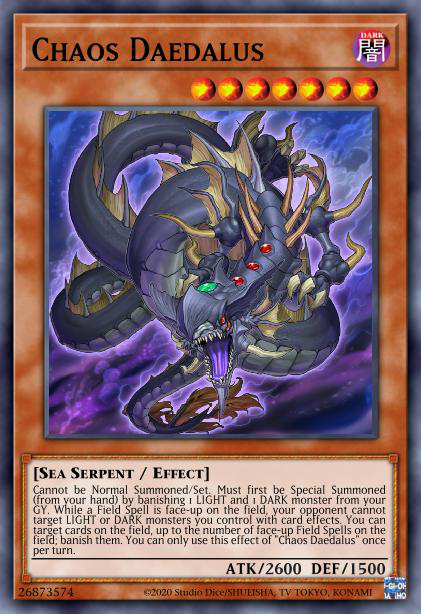

In [6]:
images = list(data_dir.glob('**/*.jpg'))
PIL.Image.open(str(images[0]))

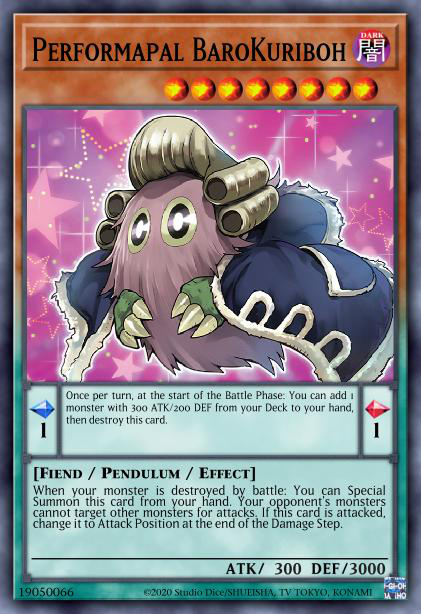

In [7]:
PIL.Image.open(str(images[1]))

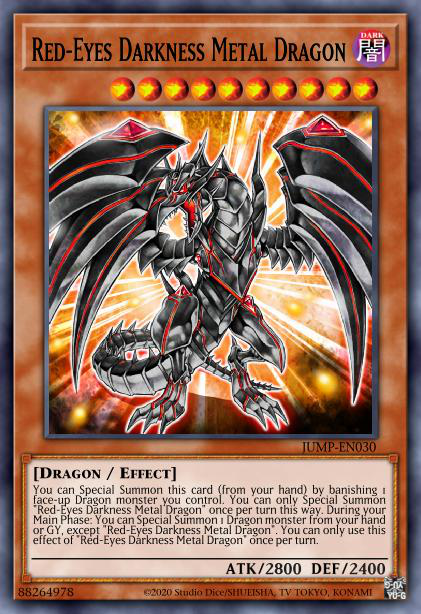

In [8]:
PIL.Image.open(str(images[700]))

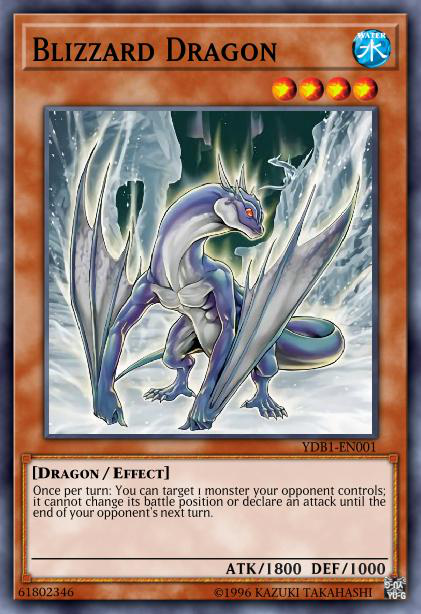

In [9]:
PIL.Image.open(str(images[-1]))

### Preprocesando las imágenes

Necesitamos recortar la parte relevante de las imágenes

In [10]:
imagen_para_probar = np.array(PIL.Image.open(images[0]))

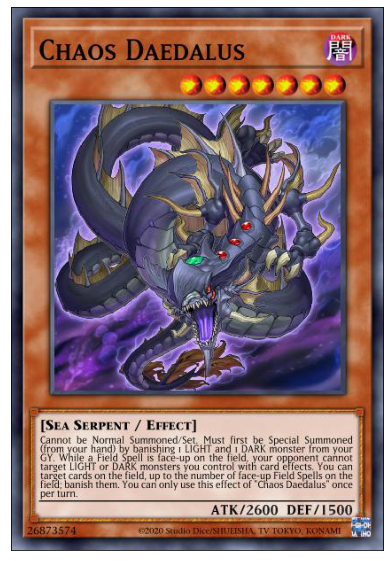

In [11]:
plt.figure(figsize = (8,10))
plt.imshow(imagen_para_probar)
plt.xticks([])
plt.yticks([]);

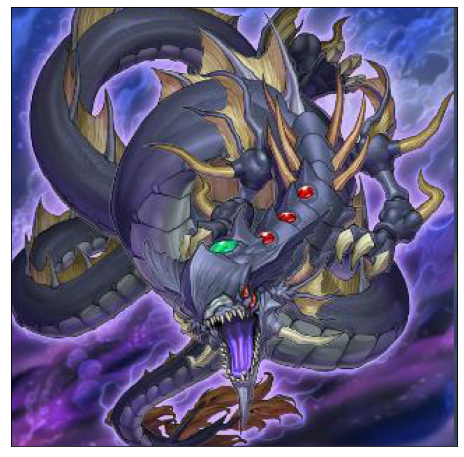

In [12]:
plt.figure(figsize = (8,10))
plt.imshow(imagen_para_probar[115:430, 55:375])
plt.xticks([])
plt.yticks([]);

In [13]:
imagen_para_probar[115:430, 55:375].shape

(315, 320, 3)

In [14]:
def obtener_ilustracion_de_carta(carta):
  """
  Recibe el path a una imagen de una carta
  Devuelve un tensor con la ilustración de la carta
  """
  return np.array(PIL.Image.open(carta))[115:430, 55:475]

## Baseline para el Style Transfer de las imágenes

Sabemos que teniendo $x_c$ imagen de contenido y $x_s$ imagen de estilo podemos generar $x^*$ que contiene el contenido de $x_c$ y el estilo de $x_s$ aplicando el algoritmo explicado en el overview. Pero en nuestro problema, no tenemos $x_s$ fijo, así que nos tenemos que enfocar en elegir el mejor $x_s$ entre las cartas, es decir, el mejor estilo entre las cartas a aplicarle a nuestra imagen de contenido. Como baseline simplemente utilizaremos KNN para promediar las 10 cartas más cercanas si las comparamos como vectores. Antes de eso reduciremos la dimensionalidad de las cartas mediante PCA para prevenir que la maldición de la dimensionalidad dañe el performance del KNN.

En primer lugar necesitamos "aplanar" las imagenes para poder utilizarla como vector para alimentar el PCA. Para eso las pasamos a blanco y negro promediando los valores RGB, las comprimimos a menor tamaño y finalmente las aplanamos.

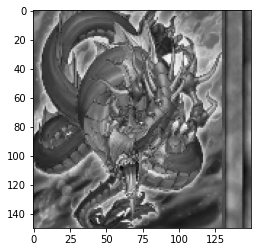

In [41]:
plt.imshow(np.mean(tf.image.resize(obtener_ilustracion_de_carta(images[0]), (150,150)), axis = -1), cmap = "gray")

In [45]:
comprimir_ilustracion = lambda ilustracion: tf.image.resize(ilustracion, (150,150))
ilustracion_a_blanco_y_negro = lambda ilustracion: np.mean(comprimir_ilustracion(ilustracion), axis = -1)
ilustracion_a_vector = lambda ilustracion: ilustracion.reshape((ilustracion.shape[1]*ilustracion.shape[0],1))
preprocesar_imagen = lambda carta: ilustracion_a_vector(ilustracion_a_blanco_y_negro(obtener_ilustracion_de_carta(carta)))

In [46]:
matriz_ilustraciones = np.concatenate([preprocesar_imagen(carta) for carta in images], axis = 1)

In [44]:
matriz_ilustraciones.shape

(22500, 11426)